# **IBM/Coursera Data Science Capstone Project Code**

## *Finding potential locations for a touristic bar*


## Code table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)

## Introduction: Business Problem <a name="introduction"></a>

The project takes place in **Lima**. Lima is the capital and the largest city of Peru, where almost 10 million people live. Lima is located on the central coast of the country, overlooking the Pacific Ocean. In 2018, of the total of foreign tourists who visited Peru, 72.4% visited Lima, the main places visited by foreigners being Miraflores: 69.1%, Downtown Lima: 62.7%, Barranco: 26.7% and San Isidro : 18.9%.

The purpose of this project is to find the most appropriate place for a **thematic bar mainly focused on tourists**. It has to be **close to points of interest or hotels** and **away from other bars**. Lima has 43 districts, two of them are the districts of interest selected, **Miraflores** and **Barranco** for being the most striking tourist districts for their cultural diversity, services, and entertainment as well as their magnificent view of the coast.

Considering the requirements we can create a map to obtain the best solution

## Data <a name="data"></a>

For our analysis, we needed to see the following aspects:
* A list of districts as well as statistical information on tourism and places of interest.
* Determine the location of bars and hotels to be analyzed.
* It is necessary to have the exact coordinates of the places defined by the client.

The data will be extract or generate from reliable sources. 
1. The list of districts and information of interest of the city of Lima will be obtained from Peruvian webs such a Prom Peru https://www.promperu.gob.pe/ and the Foreign Trade and Tourism Ministry https://www.gob.pe/mincetur
2. The number and locations of the venues of interest will be obtained using Foursquare Developers Access: https://foursquare.com/
3. The coordinates of the districts or neighborhoods defined by the client will be obtained from Geopy Geocoders: https://pypi.org/project/geopy/


### Import the libraries needed

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#! pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# library to handle JSON files
import json 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

from sklearn import metrics
from sklearn.metrics import silhouette_score

# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#! pip install folium==0.5.0
import folium # plotting library

#print('Folium installed')
print('Libraries imported.')

Libraries imported.


### Get the latitude and longitude coordinates of the districts.

As mentioned before, the districts selected was Miraflores and Barranco.

In [2]:
districts_list = ["Barranco", "Miraflores"]
Latitude = []
Longitude = []

for i in districts_list:
    address = '{}, Lima' .format(i)

    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    Latitude.append(float(latitude))
    Longitude.append(float(longitude))
   

In [3]:
districts_dict = {"District":["Barranco", "Miraflores"], 
                  "Latitude":[-12.143959, -12.12149805], 
                  "Longitude":[-77.02026805535999, -77.0259064168439]}
districts = pd.DataFrame(data=districts_dict)
districts.head()

,District,Latitude,Longitude
0,Barranco,-12.143959,-77.020268
1,Miraflores,-12.121498,-77.025906


### Visualize the districts.

Miraflores and Barranco are located at south center of Lima.

In [4]:
# using folium library.

lima_map = folium.Map(location=[latitude,longitude], zoom_start=12)

# add markers for Miraflores and Barranco to the map
for lat, lng, district in zip(districts['Latitude'], districts['Longitude'], districts['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='skyblue',
        fill_opacity=0.7,
        parse_html=False).add_to(lima_map)  
    
lima_map

### Getting Venues Using Foursquare API.

The first venues of interest were the locations of the tourist hotels. A 1500 meters radius it's assigned. 

In [5]:
search_query = 'hotel'
radius = 1500
All_venues = []

c = 0

print("The districts confirmed: ")

for i in districts.loc[:,'District']:
    CLIENT_ID = 'CPC3SSM4QSFM0V31K0A5F42OWIZYQ5DOR00UTTPGKRKFCN3N' # your Foursquare ID
    CLIENT_SECRET = 'QJ2SS02DCNXWWWNWAE0TCHRUXVTDWFTRDCU3UFJFCDSP2OYW' # your Foursquare Secret
    VERSION = '20180604'
    LIMIT = 100
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={}, {}&v={}&query={}&radius={}&limit={}' .format(CLIENT_ID, CLIENT_SECRET, Latitude[c], Longitude[c], VERSION, search_query, radius, LIMIT)    
    # Send the GET Request
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    All_venues.append(results)
    c+=1
    print(i)

print("...Ready!")

The districts confirmed: 
Barranco
Miraflores
...Ready!


### Examine the results.

In [6]:
All_venues

[{'meta': {'code': 200, 'requestId': '5f983fa12be1a37c28d85f3a'},
  'response': {'venues': [{'id': '51ba73b7498e3fb87238bf18',
     'name': 'Hotel B',
     'location': {'address': 'Av. Sáenz Peña 204',
      'crossStreet': 'San Martín',
      'lat': -12.142954386020627,
      'lng': -77.02326608635053,
      'labeledLatLngs': [{'label': 'display',
        'lat': -12.142954386020627,
        'lng': -77.02326608635053}],
      'distance': 344,
      'postalCode': '15063',
      'cc': 'PE',
      'neighborhood': 'Barranco',
      'city': 'Barranco',
      'state': 'Lima',
      'country': 'Perú',
      'formattedAddress': ['Av. Sáenz Peña 204 (San Martín)',
       'Barranco, Barranco',
       '15063',
       'Perú']},
     'categories': [{'id': '4bf58dd8d48988d1fa931735',
       'name': 'Hotel',
       'pluralName': 'Hotels',
       'shortName': 'Hotel',
       'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
        'suffix': '.png'},
       'primary': True}],
 

### Get relevant information and transform it into a dataframe.

In [7]:
# tranform venues into a dataframe
df_1 = pd.json_normalize(All_venues[0]['response']['venues'])
df_2 = pd.json_normalize(All_venues[1]['response']['venues'])

list_of_df = [df_1, df_2]
The_df = pd.concat(list_of_df)
The_df.reset_index(drop=True, inplace=True)

The_df.shape

(91, 19)

### Define information of interest and filter dataframe.

In [8]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in The_df.columns if col.startswith('location.')] + ['id']
dataframe_filtered = The_df.loc[:, filtered_columns]

# function that extracts the category of the venue

import requests # library to handle requests

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,id
0,Hotel B,Hotel,Av. Sáenz Peña 204,San Martín,-12.142954,-77.023266,"[{'label': 'display', 'lat': -12.1429543860206...",344,15063,PE,Barranco,Barranco,Lima,Perú,"[Av. Sáenz Peña 204 (San Martín), Barranco, Ba...",51ba73b7498e3fb87238bf18
1,Hotel B,Hotel,Av. San Martin,NaN,-12.144337,-77.018891,"[{'label': 'display', 'lat': -12.1443374363514...",155,NaN,PE,NaN,Lima,Lima,Perú,"[Av. San Martin, Lima, Perú]",51f70e9b498e092670961639
2,JW Marriott Hotel Lima,Hotel,"Malecon De La Reserva 615, Miraflores",NaN,-12.131734,-77.029395,"[{'label': 'display', 'lat': -12.1317336, 'lng...",1684,15074,PE,NaN,Lima,Lima,Perú,"[Malecon De La Reserva 615, Miraflores, Lima, ...",4c774dee923ba143afe066e6
3,Hotel Nirvana,Hotel,Av. Paseo De La República 6315,NaN,-12.131778,-77.021658,"[{'label': 'display', 'lat': -12.1317781225687...",1364,NaN,PE,NaN,Miraflores,Lima,Perú,"[Av. Paseo De La República 6315, Miraflores, P...",4d995f82e07ea35d1ecd0703
4,JW Marriott - Hotel Bar,Hotel Bar,Ave. Larco,Mco de la Reserva,-12.131676,-77.029451,"[{'label': 'display', 'lat': -12.1316761578210...",1693,Peru,PE,NaN,Miraflores,Lima,Perú,"[Ave. Larco (Mco de la Reserva), Miraflores, P...",4b88bc83f964a520410b32e3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Hotel José Antonio Deluxe,Hotel,Bellavista 133,NaN,-12.119827,-77.031908,"[{'label': 'display', 'lat': -12.1198274202314...",679,15074,PE,NaN,Lima,Lima,Perú,"[Bellavista 133, Lima, 15074, Perú]",58f6aae26cf01a442eac1542
87,Hotel Aloft,Hotel,"Ave. 28 De Julio N 894, Miraflores",NaN,-12.129174,-77.024033,"[{'label': 'display', 'lat': -12.1291739821494...",878,15047,PE,NaN,Lima,Reducto,Perú,"[Ave. 28 De Julio N 894, Miraflores, Lima, 150...",59fb393e28122f191e56ac7d
88,Hotel Eaperanza,Hotel,Eaperanza 348,NaN,-12.119885,-77.028359,"[{'label': 'display', 'lat': -12.119885, 'lng'...",321,NaN,PE,NaN,NaN,NaN,Perú,"[Eaperanza 348, Perú]",4f35982ce4b0fc67a738759a
89,Hotel El Condado,Hotel,NaN,NaN,-12.123867,-77.027652,"[{'label': 'display', 'lat': -12.1238674964387...",325,NaN,PE,NaN,NaN,NaN,Perú,[Perú],5115136fe4b06f50c3ba355c


### Visualizing the location of the hotels.

In [9]:
dataframe_filtered.name

0                       Hotel B
1                       Hotel B
2        JW Marriott Hotel Lima
3                 Hotel Nirvana
4       JW Marriott - Hotel Bar
                ...            
86    Hotel José Antonio Deluxe
87                  Hotel Aloft
88              Hotel Eaperanza
89             Hotel El Condado
90                  Hotel Shell
Name: name, Length: 91, dtype: object

In [10]:
# generate map centred 
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

# add markers for hotels to the map
for lat, lng, label in zip(dataframe_filtered['lat'], dataframe_filtered['lng'], dataframe_filtered['categories']):
    label = '{}'.format(dataframe_filtered)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

## Methodology <a name="methodology"></a>

In this project we will focuse on locate areas with high density of hotels and low density of Bars. 
We will require the location of both districts, as well as the location of the hotels and bars in the area. 

For the required data, the coordinates of the districts will be obtained from the Geopy Geocoders libraries.
To appreciate the obtained information, the results will be displayed using the Folium Package, which uses OpenStreetMap technology.
For the exploration of the locations of hotels and bars, we will use the foursquare API. The first venue of interest will be the locations of tourist hotels. A 1500 meters radius will be assigned.

Once the data is obtained, examined and the relevant information transformed into a dataframe, we will focus on relevant information to get the dataset ready to be able to apply unsupervised machine learning technique K-means clustering for the creation of the hotel clusters.
For that reason and a better performing of the k-means clustering, we need to decide the number of clusters that are better to use. We will use the combined method of the Elbow Method and the Silhouette Score to choose the optimal number of clusters.

In [11]:
df1 = dataframe_filtered.iloc[:, 0:6]
df1.drop(['categories', 'address', 'crossStreet'], axis=1, inplace=True)
df1.rename(columns = {'name':'Name', 'lat':'Latitude', 'lng':'Longitude'}, inplace = True) 
df1.head()

,Name,Latitude,Longitude
0,Hotel B,-12.142954,-77.023266
1,Hotel B,-12.144337,-77.018891
2,JW Marriott Hotel Lima,-12.131734,-77.029395
3,Hotel Nirvana,-12.131778,-77.021658
4,JW Marriott - Hotel Bar,-12.131676,-77.029451


In [12]:
# Fit
X = df1.values[:, 1:]

### Using the Elbow Method and the Silhouette Score.

{1: 0.00788363666333468, 2: 0.003531589944480286, 3: 0.0020370347921073485, 4: 0.0015268272152602594, 5: 0.0010301004465411243, 6: 0.0008637286600234597, 7: 0.0007251899388667148, 8: 0.0005918402749894667, 9: 0.0005039035592244258, 10: 0.00042417165021531176}


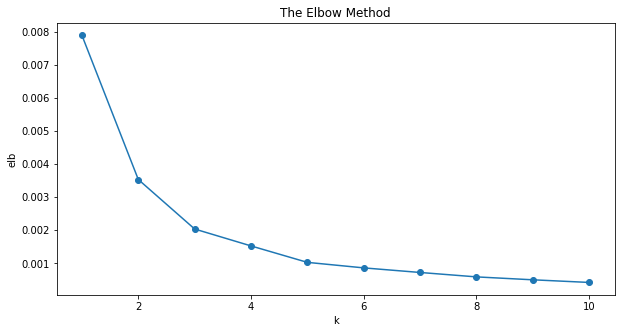

In [13]:
# The Elbow Method
elb = {}
kmax = 10

for k in range(1, kmax+1):
    elb[k] = KMeans(n_clusters=k, random_state=1).fit(X).inertia_ 
print(elb)

# plot for each k
plt.figure(figsize=(10,5))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('elb')
plt.plot(list(elb.keys()), list(elb.values()), 'o-')
plt.show()

[0.4818759105409661, 0.4993163426290412, 0.4542125590944501, 0.5092265448051955, 0.4921061277580638, 0.4951794232244793, 0.4908617795415313, 0.4713177985680135, 0.46765210782985617]
Max k: 0.5092265448051955


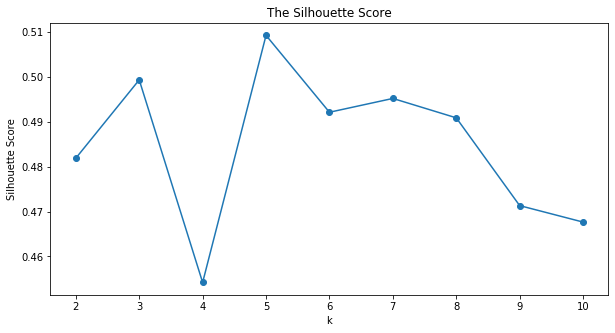

In [14]:
# The Silhouette Method
sil = []

for k in range(2, kmax+1):
    sil.append(silhouette_score(X, KMeans(n_clusters = k).fit(X).labels_))
print(sil)
print("Max k: {}" .format(max(sil)))

# plot for each k
plt.figure(figsize=(10,5))
plt.title('The Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.plot(np.arange(2, kmax+1), sil, 'o-')
plt.show()

### K-means clustering.

In [15]:
cluster_num = 5
k_means = KMeans(init="k-means++", n_clusters=cluster_num, random_state=1, n_init=12).fit(X)
labels = k_means.labels_
print(labels)

[2 2 0 4 0 0 2 2 2 4 2 2 2 2 4 4 4 4 2 4 0 4 4 0 0 0 0 4 0 0 0 0 0 0 0 0 0
 0 0 4 0 3 3 3 3 3 3 3 3 3 3 1 3 3 3 1 1 3 3 3 1 3 1 3 0 3 1 1 1 0 3 1 4 0
 0 1 0 3 1 3 3 3 1 3 3 3 1 4 3 3 3]


In [16]:
# Assigning clusters.

df1['K_clusters'] = labels
df1.head(12)

,Name,Latitude,Longitude,K_clusters
0,Hotel B,-12.142954,-77.023266,2
1,Hotel B,-12.144337,-77.018891,2
2,JW Marriott Hotel Lima,-12.131734,-77.029395,0
3,Hotel Nirvana,-12.131778,-77.021658,4
4,JW Marriott - Hotel Bar,-12.131676,-77.029451,0
5,Bayview Hotel,-12.130876,-77.029193,0
6,Hotel apurimac,-12.141363,-77.021026,2
7,Casa Falleri Boutique Hotel,-12.144083,-77.021830,2
8,Hotel Antu Suites,-12.146686,-77.021174,2
9,Hotel,-12.135748,-77.021595,4


In [17]:
# Getting the clusters size and it´s mean centers

df2= df1.groupby(df1['K_clusters'], as_index=False).mean()
df2['cluster_size'] = df1['K_clusters'].value_counts()
df2.reset_index(drop=True, inplace=True)
df2

,K_clusters,Latitude,Longitude,cluster_size
0,0,-12.132156,-77.028925,25
1,1,-12.118896,-77.033893,13
2,2,-12.145327,-77.022052,10
3,3,-12.123489,-77.027764,30
4,4,-12.132989,-77.020616,13


### Visualizing the clusters.

In [18]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(cluster_num+1)
ys = [i + x + (i*x)**2 for i in range(cluster_num+1)]
colors_array = cm.Dark2(np.linspace(0, 1, len(ys)))
Dark2 = [colors.rgb2hex(i) for i in colors_array]

# add markers for clusters to the map
markers_colors = []
for lat, lon, cluster in zip(df1.Latitude, df1.Longitude, df1.K_clusters):
    label = folium.Popup('Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=['red', 'blue', 'green', 'orange', 'purple'][cluster-1],
        fill=True,
        fill_color=['red', 'blue', 'green', 'orange', 'purple'][cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# add markers for the clusters center to the map
for lat, lng, cluster_num, clustercenter in zip(df2['Latitude'], df2['Longitude'], df2['K_clusters'], df2['cluster_size']):
    label = '{}'.format(df2)
    label = folium.Popup('Cluster center ' + str(cluster_num) + '.  Number of hotels: ' + str(clustercenter), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='black',
        fill=True,
        fill_color='#ffffff',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters) 

map_clusters

### Overlapping the bars surrounding the hotels.

As requested for this project, we locate and overlap the bars near or surrounding the hotels.

In [19]:
search_query = 'bar'
radius = 1500
All_venues = []
c = 0

for i in districts.loc[:,'District']:
    CLIENT_ID = 'CPC3SSM4QSFM0V31K0A5F42OWIZYQ5DOR00UTTPGKRKFCN3N' # your Foursquare ID
    CLIENT_SECRET = 'QJ2SS02DCNXWWWNWAE0TCHRUXVTDWFTRDCU3UFJFCDSP2OYW' # your Foursquare Secret
    VERSION = '20200219' #'20180604'
    LIMIT = 100
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Latitude[c], Longitude[c], VERSION, search_query, radius, LIMIT)
    
    # Send the GET Request
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    All_venues.append(results)
    c+=1
    print(i)

# tranform venues into a dataframe
df_1 = pd.json_normalize(All_venues[0]['response']['venues'])
df_2 = pd.json_normalize(All_venues[1]['response']['venues'])
list_of_df = [df_1, df_2]
The_df = pd.concat(list_of_df)
The_df.reset_index(drop=True, inplace=True)
print(The_df.shape)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in The_df.columns if col.startswith('location.')] + ['id']
dataframe_filtered2 = The_df.loc[:, filtered_columns]
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered2['categories'] = dataframe_filtered2.apply(get_category_type, axis=1)
# clean column names by keeping only last term
dataframe_filtered2.columns = [column.split('.')[-1] for column in dataframe_filtered2.columns]


Barranco
Miraflores
(100, 18)


### Now we can see the hotels clusters and the bars near them.

In [20]:
# generate map centred 
venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) 
# add venues as blue circle markers
for lat2, lng2, name, bars in zip(dataframe_filtered2['lat'], dataframe_filtered2['lng'], dataframe_filtered2['name'], dataframe_filtered2['categories']):
    label2 = '{}'.format(dataframe_filtered2)
    label2 = folium.Popup('Bar: ' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat2, lng2],
        radius=3,
        color='gray',
        popup=label2,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
        ).add_to(map_clusters)
# display map
map_clusters
